In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
from __future__ import division

import numpy as np
import scipy.stats as st
import pymc as pm
import pymc3 as pm3
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import re
import os
import sys
import string
import pprint
import itertools
import functools


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [5]:
sns.set()

In [6]:
dir_in = "/Users/vahram/Downloads/"
dir_out = dir_in

In [7]:
# S&P 500 data downloaded from:
# http://finance.yahoo.com/q/hp?s=%5EGSPC+Historical+Prices

###Load S&P 500 Daily & Monthly Diffs

In [8]:
d_diff = pd.read_csv(os.path.join(dir_out, "SnP_500.diff.csv"), parse_dates=[0]).set_index("Date").sort_index()
d_diff.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16427 entries, 1950-01-05 to 2015-04-20
Data columns (total 8 columns):
diff_price             16427 non-null float64
abs_diff_price         16427 non-null float64
diff_volume            16427 non-null float64
abs_diff_volume        16427 non-null float64
diff_price_lag         16427 non-null float64
abs_diff_price_lag     16427 non-null float64
diff_volume_lag        16427 non-null float64
abs_diff_volume_lag    16427 non-null float64
dtypes: float64(8)
memory usage: 1.1 MB


In [21]:
d_diff_ym = pd.read_csv(os.path.join(dir_out, "SnP_500.diff_ym.csv"), parse_dates=[[0, 1]]).set_index("year_month")
d_diff_ym.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 783 entries, 1950-02-21 to 2015-04-21
Data columns (total 2 columns):
diff_volume_ym    783 non-null float64
diff_price_ym     783 non-null float64
dtypes: float64(2)
memory usage: 18.4 KB


###Look at price diffs

In [9]:
t_params_price = st.t.fit(d_diff.diff_price)
t_params_price

(3.1570605107515535, 0.00047212291789453529, 0.0061051807701184724)

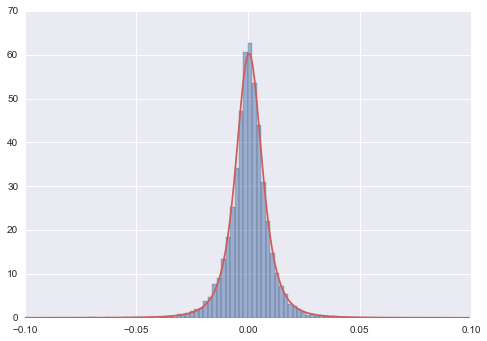

In [10]:
x = np.arange(-0.1, 0.1, 0.001)
_ = hist(d_diff.diff_price, normed=True, bins=x[::2], alpha=0.5)
_ = plot(x, st.t.pdf(x, *t_params_price), "indianred")

In [11]:
exp_params_abs_price = st.expon.fit(d_diff.abs_diff_price)
exp_params_abs_price

(-5.1103335999672821e-12, 0.0065534276077553969)

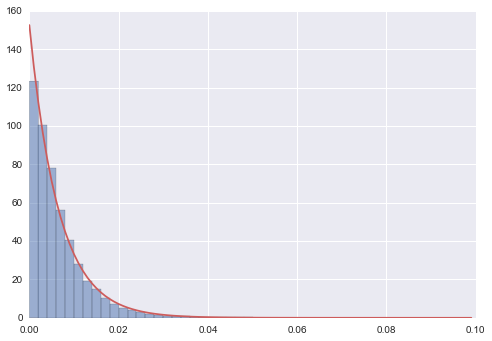

In [12]:
x = np.arange(0.0, 0.1, 0.001)
_ = hist(d_diff.abs_diff_price, normed=True, bins=x[::2], alpha=0.5)
_ = plot(x, st.expon.pdf(x, *exp_params_abs_price), "indianred")

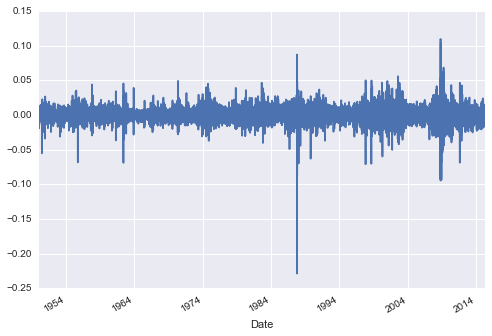

In [13]:
d_diff.diff_price.plot()

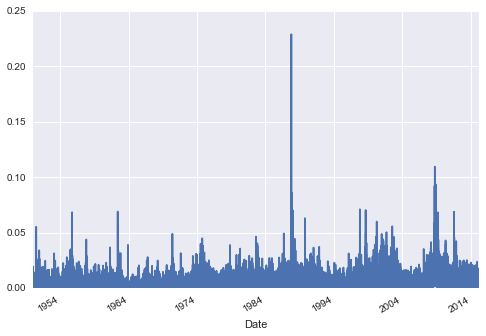

In [14]:
d_diff.abs_diff_price.plot()

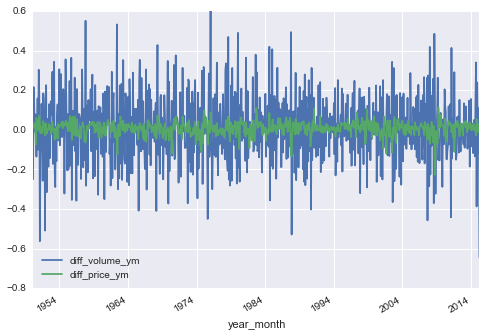

In [22]:
d_diff_ym.plot()

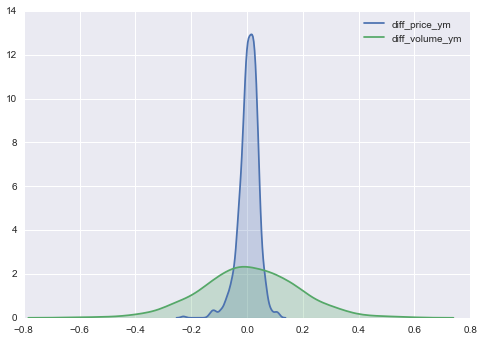

In [25]:
sns.kdeplot(d_diff_ym.diff_price_ym, shade=True)
sns.kdeplot(d_diff_ym.diff_volume_ym, shade=True)

In [28]:
d_diff_ym.describe()

,diff_volume_ym,diff_price_ym
count,783.000000,783.000000
mean,0.008871,0.006153
std,0.173269,0.034880
min,-0.644056,-0.228104
25%,-0.099737,-0.010882
50%,0.007792,0.009525
75%,0.125228,0.028424
max,0.599945,0.113529


###Changepoint model - single point, monthly data

In [27]:
# model returns as normal with unknown mean and variance, different pre and post changepoint

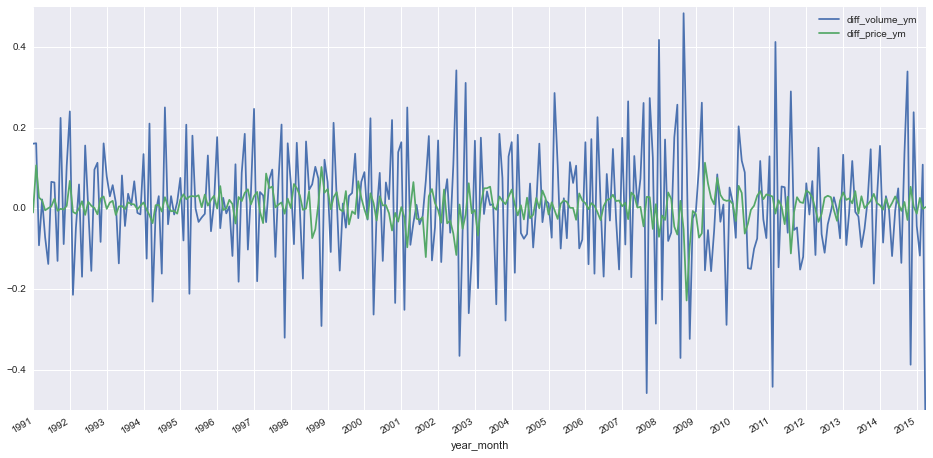

In [153]:
d_diff_ym_lim = d_diff_ym[d_diff_ym.index.year > 1990]
d_diff_ym_lim.plot(figsize=(16, 8))
_ = ylim(-0.5, 0.5)
_ = xticks(d_diff_ym_lim.index[::12])

In [133]:
n_obs = len(d_diff_ym_lim)
n_obs

292

In [134]:
price_precision_emp = np.var(d_diff_ym_lim.diff_price_ym) ** -1
price_precision_emp

770.02618855841627

In [135]:
volume_precision_emp = np.var(d_diff_ym_lim.diff_volume_ym) ** -1
volume_precision_emp

42.6697143596855

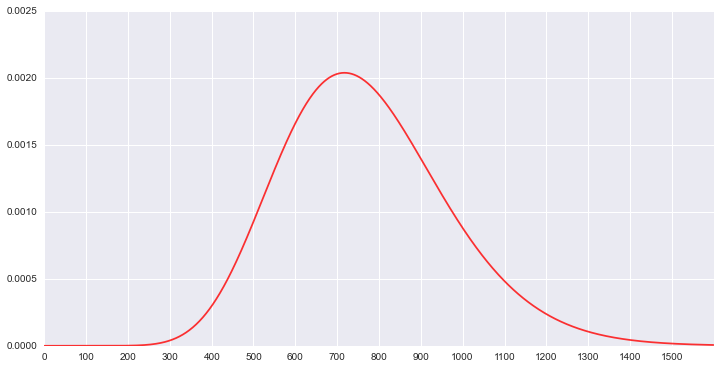

In [136]:
price_alpha = 0.1 * (n_obs / 2)
price_beta = price_alpha / price_precision_emp

x = np.arange(0, 1600, 1)
figsize(12, 6)
plot(x, st.gamma.pdf(x, price_alpha, scale=1.0/price_beta), "r-", alpha=0.8)
_ = xticks(x[::100])

In [137]:
price_alpha, price_beta

(14.600000000000001, 0.018960394096898182)

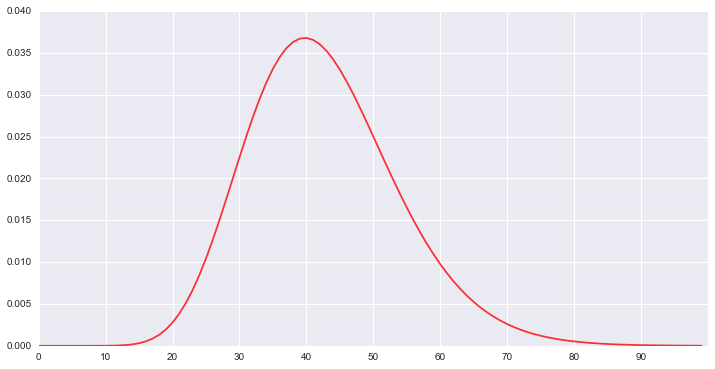

In [138]:
volume_alpha = 0.1 * (n_obs / 2)
volume_beta = volume_alpha / volume_precision_emp

x = np.arange(0, 100, 1)
figsize(12, 6)
plot(x, st.gamma.pdf(x, volume_alpha, scale=1.0/volume_beta), "r-", alpha=0.8)
_ = xticks(x[::10])

In [139]:
volume_alpha, volume_beta

(14.600000000000001, 0.34216305918827838)

In [156]:
cpt_model = pm3.Model()
with cpt_model:
    
    cpt = pm3.DiscreteUniform("cpt", 5, n_obs-5)
    
    price_tau1 = pm3.Gamma('tau1', alpha=price_alpha, beta=price_beta)
    price_tau2 = pm3.Gamma('tau2', alpha=price_alpha, beta=price_beta)

    volume_tau1 = pm3.Gamma('vtau1', alpha=volume_alpha, beta=volume_beta)
    volume_tau2 = pm3.Gamma('vtau2', alpha=volume_alpha, beta=volume_beta)

    idx = np.arange(n_obs)
    tau = pm3.switch(cpt >= idx, price_tau1, price_tau2)
    vtau = pm3.switch(cpt >= idx, volume_tau1, volume_tau2)
    
    price_diff = pm3.Normal("price_diff", mu=0.0, tau=tau,
                            observed=d_diff_ym_lim.diff_price_ym.values)
    volume_diff = pm3.Normal("volume_diff", mu=0.0, tau=vtau,
                            observed=d_diff_ym_lim.diff_volume_ym.values)


In [157]:
with cpt_model:
    
    start = {"price_tau1": price_precision_emp,
             "price_tau2": price_precision_emp,
             "volume_tau1": volume_precision_emp,
             "volume_tau2": volume_precision_emp}

    step1 = pm3.Slice([price_tau1, price_tau2, volume_tau1, volume_tau2])
    step2 = pm3.Metropolis([cpt])
    
    tr = pm3.sample(20000, tune=1000, start=start, step=[step1, step2])

 [-----------------100%-----------------] 20000 of 20000 complete in 65.4 sec

In [158]:
cpt_model.vars

[cpt, tau1, tau2, vtau1, vtau2]

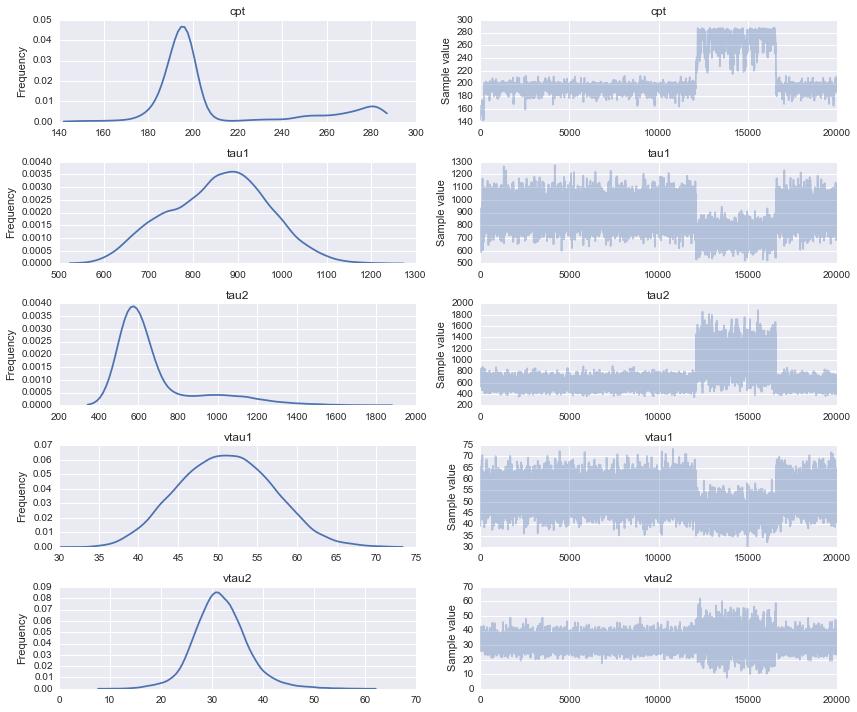

In [159]:
figsize(16, 8)
_ = pm3.traceplot(tr, cpt_model.vars)

In [160]:
pm3.stats.summary(tr, cpt_model.vars)


cpt:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  209.944          32.255           3.112            [183.000, 285.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  178.000        192.000        197.000        202.000        283.000


tau1:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  857.445          110.889          7.536            [642.428, 1062.473]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  644.748        778.875        864.015        934.973        1065.524


tau2:
 
  Mean             SD               MC Error         95% HPD interval
  ------------

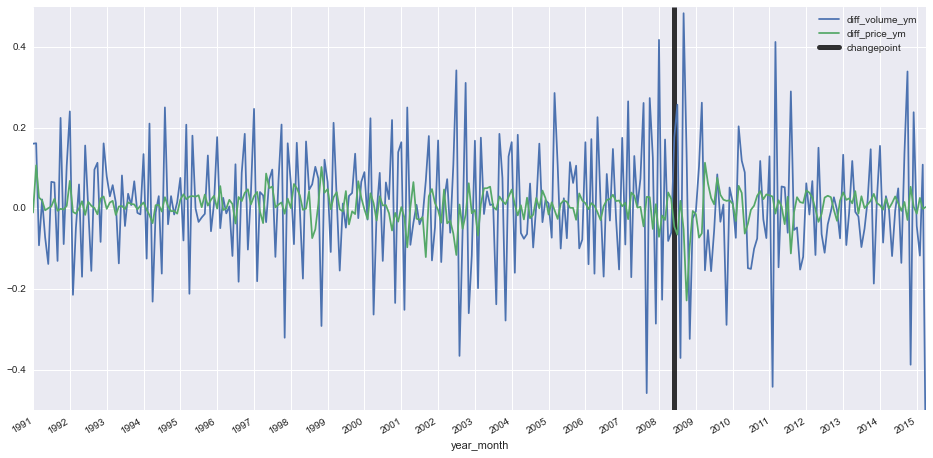

In [178]:
dt_changepoint = d_diff_ym_lim.index[int(tr["cpt"].mean())]

d_diff_ym_lim = d_diff_ym[d_diff_ym.index.year > 1990]
d_diff_ym_lim.plot(figsize=(16, 8))
_ = ylim(-0.5, 0.5)
_ = vlines(dt_changepoint, -0.5, 0.5,
           "k", linewidth=5, alpha=0.8, label="changepoint")
_ = xticks(d_diff_ym_lim.index[::12])
_ = legend(loc="best")

###Build and fit a stochastic volatility model

In [2]:
# Based on:
# http://nbviewer.ipython.org/github/pymc-devs/pymc3/blob/master/pymc3/examples/stochastic_volatility.ipynb
# http://www.stat.columbia.edu/~gelman/research/published/nuts.pdf

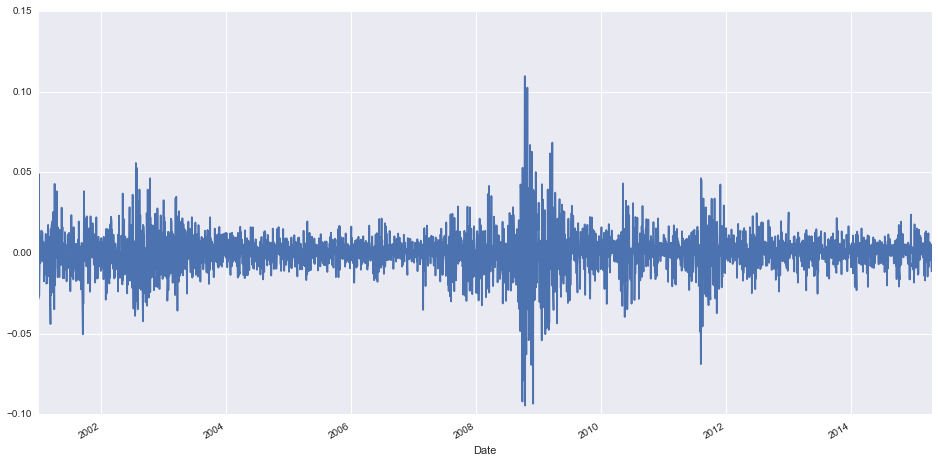

In [104]:
s_diff_price = d_diff.diff_price[d_diff.index.year > 2000]
s_diff_price.plot(figsize=(16, 8))

In [49]:
n = len(s_diff_price)
n

3594

In [54]:
from pymc3.distributions.timeseries import GaussianRandomWalk
from scipy import optimize

In [53]:
sv_model = pm3.Model()
with sv_model:

    lambda_prior_sigma = 1.0 / 0.02
    lambda_prior_nu = 1.0 / 10.0
    
    sigma, log_sigma = sv_model.TransformedVar('sigma',
                                               pm3.Exponential.dist(lambda_prior_sigma, testval=0.1),
                                               pm3.logtransform)
    nu = pm3.Exponential('nu', lambda_prior_nu)
    s = GaussianRandomWalk('s', sigma**-2, shape=n)

    r = pm3.T('r', nu, lam=pm3.exp(-2*s), observed=s_diff_price.values)

In [55]:
with sv_model:
    start = pm3.find_MAP(vars=[s], fmin=optimize.fmin_l_bfgs_b)

In [63]:
start

{'log_sigma': array(-2.3025850929940455),
 'nu': array(6.931471824645996),
 's': array([-4.17040811, -4.1864827 , -4.24006796, ..., -5.19596782,
        -5.18681349, -5.16786236])}

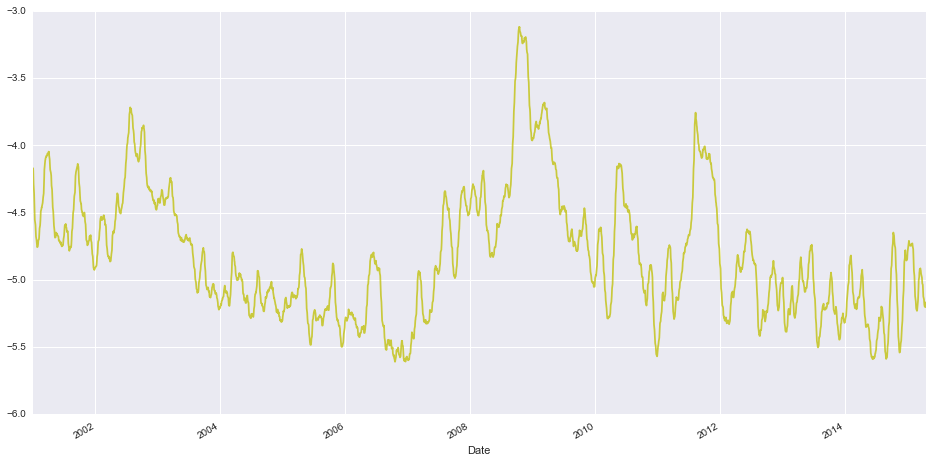

In [117]:
pd.Series(index=s_diff_price.index, data=start["s"]).plot(figsize=(16, 8), color="y", alpha=0.75)

In [65]:
with sv_model:
    step = pm3.NUTS(scaling=start)
    start2 = pm3.sample(500, step, progressbar=False)[-1]

    # Start next run at the last sampled position.
    step = pm3.NUTS(scaling=start2)
    trace = pm3.sample(2000, step, start=start2, progressbar=True)

 [-----------------100%-----------------] 2001 of 2000 complete in 904.8 sec

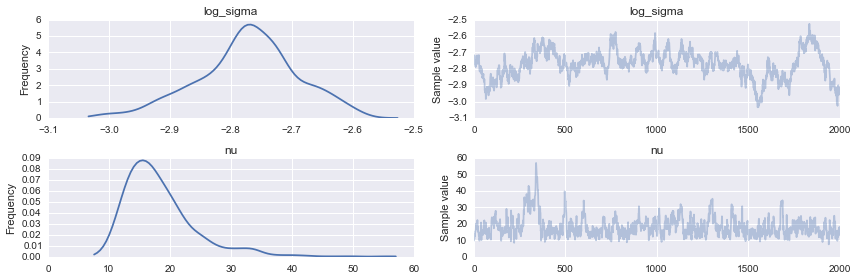

In [72]:
figsize(16, 8)
_ = pm3.traceplot(trace, sv_model.vars[:-1])

In [158]:
pm3.stats.summary(trace, sv_model.vars[:-1])


log_sigma:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -2.772           0.083            0.008            [-2.938, -2.612]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -2.951         -2.820         -2.769         -2.722         -2.618


nu:
 
  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  18.383           6.100            0.469            [9.426, 31.342]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  10.797         14.277         16.989         20.726         33.967



In [82]:
d_trace_s = pd.DataFrame(data=trace[s][::10]).T.set_index(s_diff_price.index)

In [87]:
cols_desc = d_trace_s.describe().index
cols_desc

Index([u'count', u'mean', u'std', u'min', u'25%', u'50%', u'75%', u'max'], dtype='object')

In [88]:
d_trace_s.describe().T.rename(columns={c: "s_%s" % c for c in cols_desc}).describe()

,s_count,s_mean,s_std,s_min,s_25%,s_50%,s_75%,s_max
count,200,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,3594,-4.720995,0.479351,-5.758273,-5.073659,-4.801803,-4.423800,-2.960117
std,0,0.020032,0.012683,0.086824,0.022993,0.024013,0.029623,0.126826
min,3594,-4.790637,0.441315,-6.098403,-5.147093,-4.862259,-4.531506,-3.310073
25%,3594,-4.733431,0.470858,-5.815427,-5.089445,-4.816880,-4.442223,-3.053585
50%,3594,-4.719585,0.479357,-5.755007,-5.072374,-4.803711,-4.422724,-2.952970
75%,3594,-4.707285,0.488373,-5.693448,-5.058341,-4.784844,-4.402315,-2.867110
max,3594,-4.671260,0.512074,-5.518128,-5.020776,-4.739999,-4.326210,-2.499279


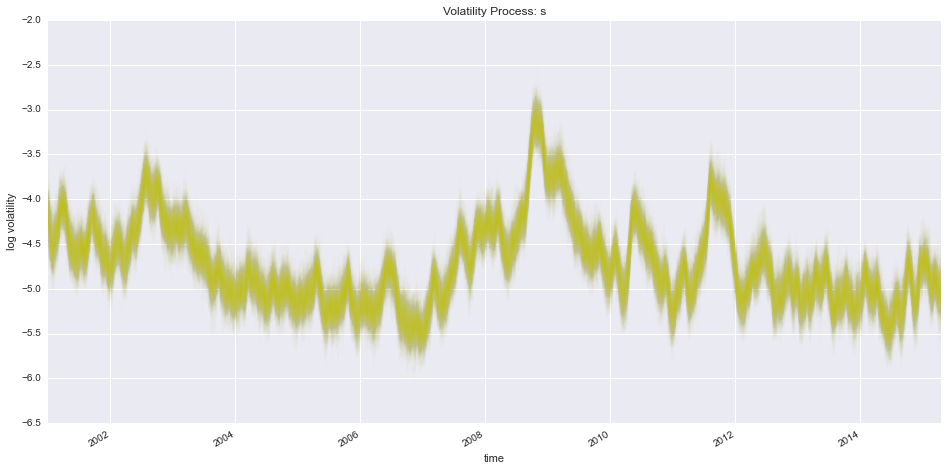

In [126]:
_ = d_trace_s.plot(figsize(16, 8), color="y", alpha=.01, legend=False, title="Volatility Process: %s" % str(s))
_ = xlabel('time')
_ = ylabel('log volatility')


In [124]:
sd_est = np.exp(d_trace_s)

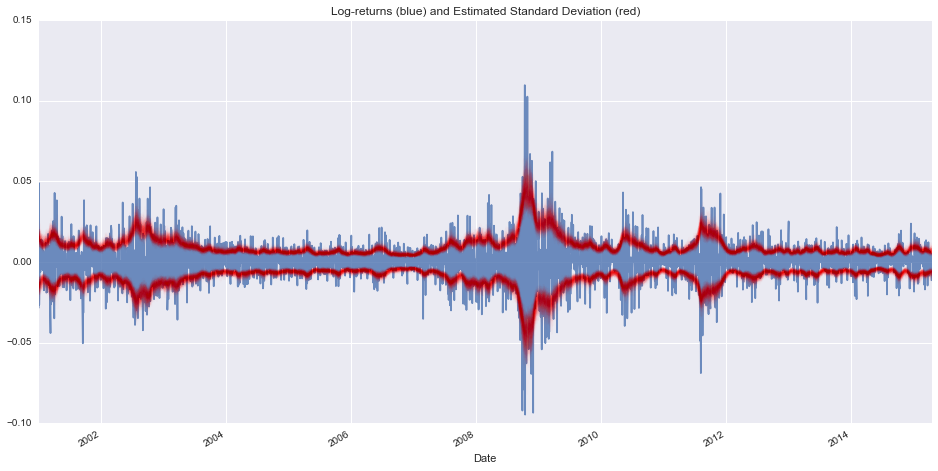

In [127]:
fig, ax = plt.subplots()
ax.set_title("Log-returns (blue) and Estimated Standard Deviation (red)")
s_diff_price.plot(ax=ax, alpha=0.8)
sd_est.plot(ax=ax, color="r", alpha=.01, legend=False)
(-sd_est).plot(ax=ax, color="r", alpha=.01, legend=False)


In [128]:
# compare with basic rolling std measure

In [139]:
sd_roll_10 = pd.rolling_std(s_diff_price, 10)
sd_roll_50 = pd.rolling_std(s_diff_price, 50)

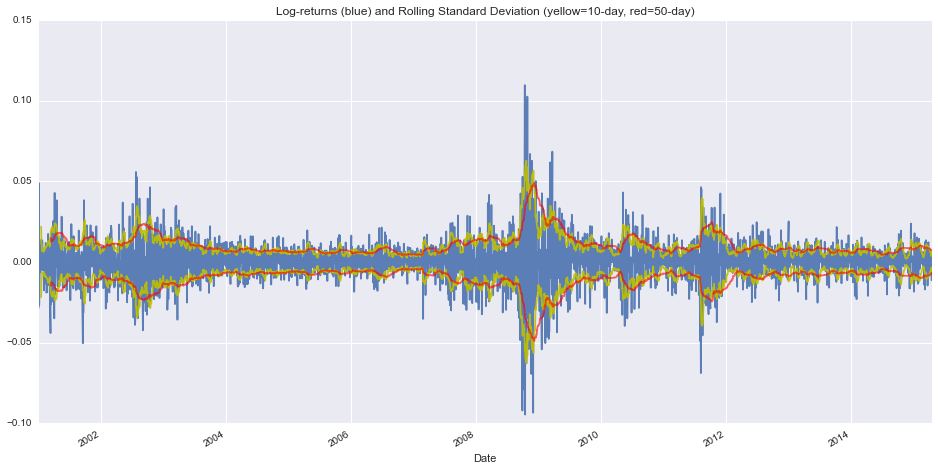

In [155]:
fig, ax = plt.subplots()
ax.set_title("Log-returns (blue) and Rolling Standard Deviation (yellow=10-day, red=50-day)")
s_diff_price.plot(ax=ax, alpha=0.9)
sd_roll_10.plot(ax=ax, color="y", alpha=0.9)
(-sd_roll_10).plot(ax=ax, color="y", alpha=0.9)
sd_roll_50.plot(ax=ax, color="r", alpha=0.6)
(-sd_roll_50).plot(ax=ax, color="r", alpha=0.6)
